In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import math
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')
from matplotlib import gridspec

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

def mdtest(fname):
    with open(fname) as f:
        start = end = ""
        data = json.load(f)
        for line in data['stdout_lines']:
            if "started" in line: start = line.split()[4]
            if "finished" in line: end = line.split()[4]
        result = to_seconds(end) - to_seconds(start)
        if result < 0: return 0
        return result
    
def parse(expdir):
    df = pd.DataFrame(columns=['job', 'nfile', 'rtime', 'run'])
    for run in [0, 1, 2]:
        for s in ["stream", "nostream"]:
            rundir = expdir + '-run' + str(run) + '/100000/summary-'
            with open(rundir + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), '100000')
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s
                d['run'] = run
                df = df.append(d, ignore_index=True)

            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s] + [float('100000')] + [mdtest(rundir + 'rpcs-' + s + '.txt')] + [run]
        del df['nfile']
    return df.pivot(index='run', values='rtime', columns='job')
    
def transfertime():
    with open("../results-all/dummy100k.txt") as f:
        for line in f:
            y = line
    return float(y)

def relabel(df):
    for j in ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']:
        for s in ["stream", "nostream"]:
            dfs = [j + '-' + s + '-run0']
            df[j + '-' + s] = df[dfs].mean(axis=1)
    return df

# calculate the phase execution times
def calculate(df):
    df['RPCs'] =              df['RPCs-nostream']
    df['stream'] =            df['RPCs-stream'] - df['RPCs-nostream']
    df['create'] =            df['create-nostream']
    df['local persist'] =     df['save-nostream'] - df['create']
    df['global persist'] =    df['persist-nostream']
    df['volatile apply'] =    df['v.apply-nostream'] + transfertime()
    df['nonvolatile apply'] = df['apply-nostream'] - df['create']
    dur = pd.DataFrame(); con = pd.DataFrame()
    dur['stream'] = df['stream']
    dur['local\npersist'] = df['local persist']
    dur['global\npersist'] = df['global persist']
    con['create'] = df['create'] 
    con['volatile apply'] = df['volatile apply']
    con['nonvolatile apply'] = df['nonvolatile apply']
    con['RPCs'] = df['RPCs']
    return dur, con


       POSIX   DeltaFS  RAMDisk     HDFS
0  20.295997  1.210859      1.0  2.29455


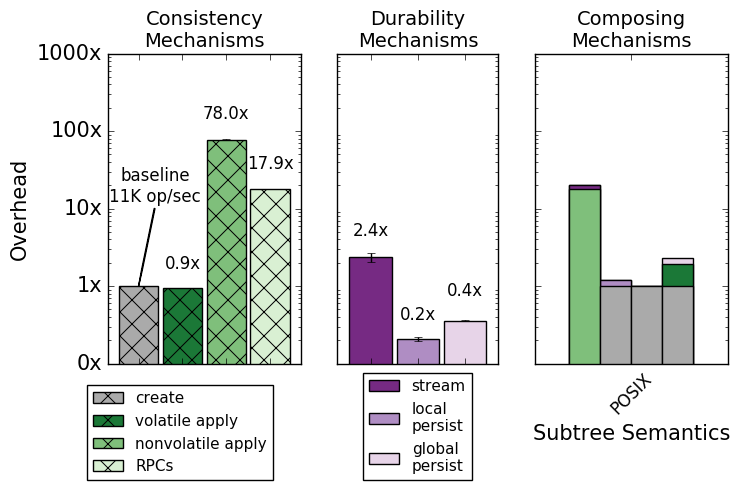

In [26]:
font = {'size'   : 15}; matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1.2, 1, 1.2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# mechanisms normalized to 'create'
df = parse('../results-cloudlab-nostream')
durability, consistency = calculate(df)
c = consistency/consistency['create'].mean()
d = durability/consistency['create'].mean()
(c.mean()).plot.bar(ax=ax0, yerr=c.std(), width=0.9, label='', color=['#aaaaaa', '#1b7837',  '#7fbf7b', '#d9f0d3'])
(d.mean()).plot.bar(ax=ax1, yerr=d.std(), width=0.9, label='', color=['#762a83', '#af8dc3', '#e7d4e8'])

# compositions are done in layers
def layer(layers, label, values):
    means = [v.mean() for v in values]
    layers[0][label] = [np.sum(means)]
    layers[1][label] = [np.sum(means[:2])]
    layers[2][label] = [np.sum(means[:1])]
    return layers
n = ['POSIX', 'DeltaFS', 'RAMDisk', 'HDFS']
l = [pd.DataFrame(columns=n), pd.DataFrame(columns=n), pd.DataFrame(columns=n)]
l = layer(l, 'POSIX',   [c['RPCs'], d['stream']])
l = layer(l, 'DeltaFS', [c['create'], d['local\npersist']])
l = layer(l, 'RAMDisk', [c['create']])
l = layer(l, 'HDFS',    [c['create'], c['volatile apply'], d['global\npersist']])
l[0].plot.bar(ax=ax2, width=0.9, color=['black', 'black', 'black', '#e7d4e8'])
l[1].plot.bar(ax=ax2, width=0.9, color=['#762a83', '#af8dc3',  'black', '#1b7837'])
l[2].plot.bar(ax=ax2, width=0.9, color=['#7fbf7b', '#aaaaaa',  '#aaaaaa', '#aaaaaa'])
ax2.legend().remove()
ax2.set_yticks([])
ax2.set_title("Composing\nMechanisms", fontsize=14)
#ax2.set_xticks([1.5, 2.5, 3.5, 4.5])
ax2.set_xticklabels(l[0].columns, rotation=45, fontsize=12)
ax2.set_xlabel("Subtree Semantics", fontsize=15)
print l[0]

# legends
for bar, label in zip(ax0.patches, c.columns):
    bar.set_hatch('x')
    bar.set_label(label)
ax0.legend(fontsize=11, loc='lower left', bbox_to_anchor=(-0.15, -0.4))    
for bar, label in zip(ax1.patches, d.columns):
    bar.set_label(label)    
ax1.legend(fontsize=11, loc='lower left', bbox_to_anchor=(0.11, -0.4))

# format
for axis in [ax0, ax1, ax2]:
    axis.set_yscale('log')    
    axis.set_ylim([10**-1,10**3])

ax0.set_title("Consistency\nMechanisms", fontsize=14)
ax0.set_ylabel("Overhead")
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
ax0.set_xticklabels([])    
ax1.set_title("Durability\nMechanisms", fontsize=14)
ax1.set_yticks([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
#ax2.set_xticklabels([])

# annotate
bops = str(int(round((100000/consistency['create'].mean())/1024))) + "K op/sec"
arrw = dict(facecolor='black', headwidth=0.5, width=0.5, shrink=1)
args = {'horizontalalignment': 'center', 'verticalalignment': 'top', 'fontsize': 12, 'arrowprops': arrw}
ax0.annotate('baseline\n' + bops, xy=(0, 1), xytext=(0.38, 35), **args)

def annotate_overhead(ax, df, args, i=0, inc=1):
    args = {'fontsize': 12, 'horizontalalignment': 'center'}
    for c in df.columns:
        if c != 'create':
            top = round(df[c].mean(), 1)
            ax.annotate(str(top) + "x\n", xy=(i, top), xytext=(i, top), **args)
            i += inc
args = {'fontsize': 12, 'horizontalalignment': 'center'}
annotate_overhead(ax0, c, args, i=1)
annotate_overhead(ax1, d, args, i=0)
#annotate_overhead(ax2, l[0], args, i=-1, inc=0.2)
#l[0]
#fig.savefig('../../../paper/graphs/composable-mechanisms.png', dpi=400, bbox_inches='tight')

In [4]:
#c2 = pd.DataFrame(columns=['POSIX', 'DeltaFS', 'RAMDisk', 'HDFS'])
#c1 = pd.DataFrame(columns=['POSIX', 'DeltaFS', 'RAMDisk', 'HDFS'])
#c0 = pd.DataFrame(columns=['POSIX', 'DeltaFS', 'RAMDisk', 'HDFS'])
#c2['POSIX']   = c['RPCs'] + d['stream']
#c2['DeltaFS'] = c['create'] + d['local\npersist']
#c2['RAMDisk'] = c['create']
#c2['HDFS']    = c['create'] + c['volatile apply'] + d['global\npersist']
#c1['POSIX']   = c['RPCs']  ; c0['POSIX']   = [0, 0, 0]
#c1['DeltaFS'] = c['create']; c0['DeltaFS'] = [0, 0, 0]
#c1['RAMDisk'] = c['create']; c0['RAMDisk'] = [0, 0, 0]
#c1['HDFS']    = c['create'] + c['volatile apply']; c0['HDFS'] = c['create'] 
#c2.mean().plot.bar(ax=ax2, width=0.9, color=['#aaaaaa', '#1b7837',  '#7fbf7b', '#d9f0d3'])
#c1.mean().plot.bar(ax=ax2, width=0.9, color=['#aaaaaa', '#1b7837',  '#7fbf7b', '#d9f0d3'])
#c0.mean().plot.bar(ax=ax2, width=0.9, color=['#aaaaaa', '#1b7837',  '#7fbf7b', '#d9f0d3'])
#print c2
#def plot_stacked(ax, x, color, y):
#    ax.bar([x], y, width=1, color=color)
#labels = []
#labels.append("POSIX")
#plot_stacked(ax2, 1, '#762a83', c['RPCs'].mean() + d['stream'].mean())
#plot_stacked(ax2, 1, '#d9f0d3', c['RPCs'].mean().mean())
#labels.append("DeltaFS")
#plot_stacked(ax2, 2, '#af8dc3', c['create'].mean() + d['local\npersist'].mean())
#plot_stacked(ax2, 2, '#aaaaaa', c['create'].mean())
#labels.append("RAMDisk")
#plot_stacked(ax2, 3, '#aaaaaa', 1)
#labels.append("HDFS")
#plot_stacked(ax2, 4, '#e7d4e8', c['create'].mean() + c['volatile apply'].mean() + d['global\npersist'].mean())
#plot_stacked(ax2, 4, '#1b7837', c['create'].mean() + c['volatile apply'].mean())
#plot_stacked(ax2, 4, '#aaaaaa', c['create'].mean())
#for bar, val in zip(ax2.patches, ['', 'x', ' ', 'x', 'x', ' ', 'x', 'x']):
#    bar.set_hatch(val)